encoder, decoder : dense layer 하나씩

MNIST 데이터셋

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
235/235 [==============================] - 8s 31ms/step - loss: 0.2368 - val_loss: 0.1681
Epoch 2/10
235/235 [==============================] - 7s 29ms/step - loss: 0.1522 - val_loss: 0.1387
Epoch 3/10
235/235 [==============================] - 8s 35ms/step - loss: 0.1332 - val_loss: 0.1269
Epoch 4/10
235/235 [==============================] - 5s 21ms/step - loss: 0.1252 - val_loss: 0.1216
Epoch 5/10
235/235 [==============================] - 4s 17ms/step - loss: 0.1206 - val_loss: 0.1181
Epoch 6/10
235/235 [==============================] - 5s 21ms/step - loss: 0.1176 - val_loss: 0.1160
Epoch 7/10
235/235 [==============================] - 4s 16ms/step - loss: 0.1154 - val_loss: 0.1142
Epoch 8/10
235/235 [==============================] - 4s 15ms/step - loss: 0.1139 - val_loss: 0.1132
Epoch 9/10
235/235 [==============================] - 5s 20ms/step - loss: 0.1129 - val_loss: 0.1124
Epoch 10/10
313/313 [=====

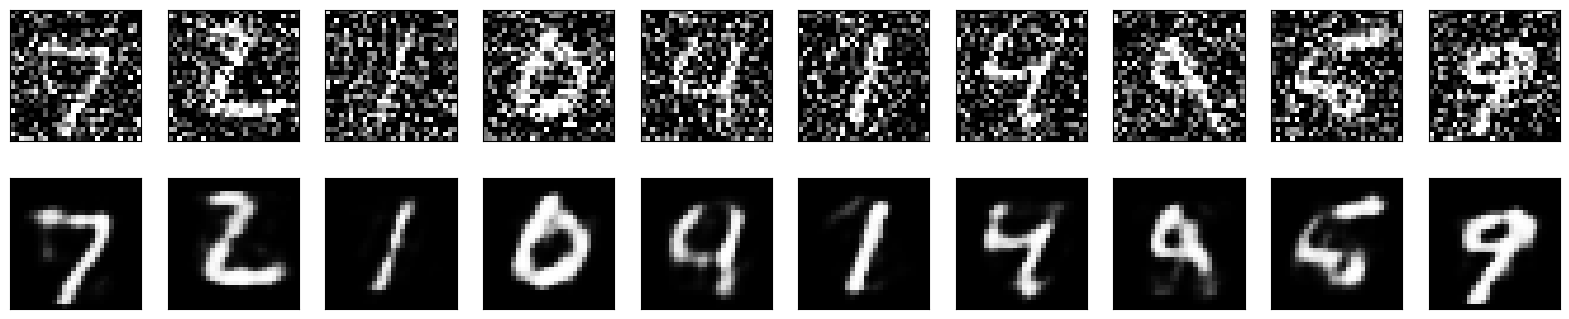

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# MNIST 데이터 로드
(x_train, _), (x_test, _) = mnist.load_data()

# 데이터 정규화 및 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 데이터를 벡터로 변환
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# 이미지에 노이즈 추가
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) # 정규분포로 노이즈 추가(평균 0, 표준편차 1 ; 표준 정규분포)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# 노이즈가 추가된 이미지를 0과 1 사이로 클리핑
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Autoencoder 모델 정의
## 단순 dense layer로 구성
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img) # hidden layer 역할
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 모델 훈련
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test))

# 노이즈가 있는 테스트 이미지 입력
encoded_imgs = autoencoder.predict(x_test_noisy)

# 결과를 플로팅
n = 10  # 몇 개의 이미지를 플로팅할지 결정
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 노이즈 제거된 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Convolutional Neural Network

MNIST 데이터셋


노이즈가 포함된 데이터를 입력으로 받아 원본 데이터를 출력하도록 모델을 구성한다.

모델 학습 후, 노이즈가 포함된 테스트 데이터를 이용해 잡음을 잘 제거하는지 확인해 본다.

In [5]:
# 모듈 불러오기

from tensorflow.keras.datasets import mnist
import pickle
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [6]:
# MNIST 데이터 로드
(x_train, _), (x_test, _) = mnist.load_data()

# 데이터 정규화 및 전처리
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

X_train = x_train[:3000, :]
X_test = x_test[:100, :]

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
# 1) 데이터 준비
#data_path = "..."
#with open(f"{data_path}/mnist.pickle", 'rb') as f:
#    mnist = pickle.load(f)
#X_train = mnist.data[:3000, :] / 255.0
#X_test = mnist.data[3000:3100, :] / 255.0

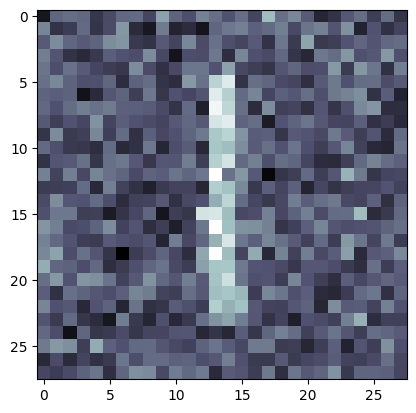

In [11]:
# 2) 노이즈 삽입
X_train_n = X_train + 0.3*np.random.normal(size=X_train.shape)
X_test_n = X_test + 0.3*np.random.normal(size=X_test.shape)
plt.imshow(X_train_n[102].reshape(28, 28), cmap=plt.cm.bone)
plt.show()

In [12]:
# 3) 값 범위 clip
X_train_n_clipped = np.clip(X_train_n, 0.0, 1.0)
X_test_n_clipped = np.clip(X_test_n, 0.0, 1.0)

In [15]:
X_train.shape

(3000, 28, 28)

In [16]:
X_train_n.shape

(3000, 28, 28)

In [17]:
# 4) 데이터 shape 변경 및 channel 축 추가
X_train = X_train.reshape(-1, 28, 28) # -1은 원래 SIZE? 를 유지해라// -> (3000, 28, 28)
X_train = X_train[:, :, :, np.newaxis] # newaxis : 흑백 channel 축 추가
X_train_n = X_train_n.reshape(-1, 28, 28)
X_train_n = X_train_n[:, :, :, np.newaxis]
X_test = X_test.reshape(-1, 28, 28)
X_test = X_test[:, :, :, np.newaxis]
X_test_n = X_test_n.reshape(-1, 28, 28)
X_test_n = X_test[:, :, :, np.newaxis]

In [18]:
X_train.shape

(3000, 28, 28, 1)

In [19]:
# 5) 파라미터 설정
n_height = X_train_n.shape[1] # 28
n_width = X_train_n.shape[2] # 28
n_channel = X_train_n.shape[3] # 흑백: 1

In [20]:
# 6) 모델 레이어 설정
x_Input = Input(batch_shape=(None, n_height, n_width, n_channel)) # 인코더 입력
# 인코더 부분
e_conv = Conv2D(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(x_Input)
e_pool = MaxPooling2D(pool_size=(2, 2), strides=1, padding='SAME')(e_conv)
# 디코더 부분
d_conv = Conv2DTranspose(filters=10, kernel_size=(3, 3), strides=1, padding='SAME', activation='relu')(e_pool)
x_Output = Conv2D(filters=1, kernel_size=(3, 3), strides=1, padding='SAME', activation='sigmoid')(d_conv)

In [21]:
# 7) 모델 구성
model = Model(x_Input, x_Output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005))
print("====== 모델 전체 구조 =====")
print(model.summary())

# 0과 1 사이로 구성되어 있는 픽셀 값의 특성을 살리기 위해 두 조합(sigmoid, binary crossentropy)을 사용

====== 모델 전체 구조 =====
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 10)        0         
 D)                                                              
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 10)        910       
 anspose)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 1)         91        
                                                                 
Total params: 1101 (4.30 KB)
Trainable 

In [22]:
# 모델 학습
EPOCHS = 500
BATCH = 300
hist = model.fit(X_train_n, X_train, epochs=EPOCHS, batch_size=BATCH, shuffle=True)

Epoch 1/500
10/10 [==============================] - 4s 343ms/step - loss: 0.6684
Epoch 2/500
10/10 [==============================] - 5s 568ms/step - loss: 0.6031
Epoch 3/500
10/10 [==============================] - 3s 347ms/step - loss: 0.5364
Epoch 4/500
10/10 [==============================] - 3s 344ms/step - loss: 0.4718
Epoch 5/500
10/10 [==============================] - 4s 354ms/step - loss: 0.4035
Epoch 6/500
10/10 [==============================] - 5s 532ms/step - loss: 0.3384
Epoch 7/500
10/10 [==============================] - 3s 337ms/step - loss: 0.2810
Epoch 8/500
10/10 [==============================] - 3s 337ms/step - loss: 0.2342
Epoch 9/500
10/10 [==============================] - 4s 420ms/step - loss: 0.2036
Epoch 10/500
10/10 [==============================] - 5s 459ms/step - loss: 0.1859
Epoch 11/500
10/10 [==============================] - 3s 336ms/step - loss: 0.1754
Epoch 12/500
10/10 [==============================] - 3s 346ms/step - loss: 0.1685
Epoch 13/500


In [26]:
# 8) 화면에 이미지 그림
def showImage(images):
    n = 0
    for k in range(2):
        plt.figure(figsize=(8, 2))
        for i in range(5):
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(images[n])
            plt.gray()
            ax.get_axis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            n += 1
        plt.show()

잡음 제거 전 테스트 데이터 10개
4/4 [==============================] - 0s 32ms/step
잡음 제거 후 테스트 데이터 10개


AttributeError: ignored

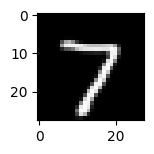

In [30]:
# 9) 노이즈 포함된 테스트 데이터 잡음 제거
# 비교 위해 먼저 그림 그리기
print("잡음 제거 전 테스트 데이터 10개")
showImage(X_test_n)
# 학습된 모델 통과
X_test_detected = model.predict(X_test_n)
# 잡음 제거 후 그림 그리기
print("잡음 제거 후 테스트 데이터 10개")
showImage(X_test_detected)